# LPA

In [1]:
import time
import numpy as np
import scipy.io as sio
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from image_to_NNgraph import *

## Load data

In [2]:
bahoc_W = sio.loadmat(file_name="./20newsgroups/baseballhockey/baseballhockey_graph.mat")['W']
pcmac_W = sio.loadmat(file_name="./20newsgroups/pcmac/pcmac_graph.mat")['W']
wimac_W = sio.loadmat(file_name="./20newsgroups/windowsmac/windowsmac_graph.mat")['W']
bahoc_Y = sio.loadmat(file_name="./20newsgroups/baseballhockey/baseballhockey_Y.mat")['Y']
pcmac_Y = sio.loadmat(file_name="./20newsgroups/pcmac/pcmac_Y.mat")['Y']
wimac_Y = sio.loadmat(file_name="./20newsgroups/windowsmac/windowsmac_Y.mat")['Y']

In [3]:
bahoc_label = dict(zip(np.arange(bahoc_Y.shape[0]), bahoc_Y[:,0]))
pcmac_label = dict(zip(np.arange(pcmac_Y.shape[0]), pcmac_Y[:,0]))
wimac_label = dict(zip(np.arange(wimac_Y.shape[0]), wimac_Y[:,0]))

bahoc_G = nx.Graph(bahoc_W)
pcmac_G = nx.Graph(pcmac_W)
wimac_G = nx.Graph(wimac_W)

nx.set_node_attributes(G=bahoc_G, name='label', values=bahoc_label)
nx.set_node_attributes(G=pcmac_G, name='label', values=pcmac_label)
nx.set_node_attributes(G=wimac_G, name='label', values=wimac_label)

In [4]:
bahoc_nodes = pd.DataFrame()
bahoc_nodes['label'] = nx.get_node_attributes(bahoc_G, 'label').values()
testing_nodes = pd.DataFrame()
testing_nodes['label'] = nx.get_node_attributes(bahoc_G, 'label').values()

## Model

In [104]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn import metrics
from GraphModel import GraphModel

# training params
DEFAULT_PARAMS = {
    'NUM_CLASSES': 2,
    'NUM_TRIALS': 10,
    'NUM_TRAIN': range(4, 100, 10)
}
# Currently only support for incremental integer labels (starts from 0),
# nodes without labels should be left with ''


class LPA(GraphModel):
    def __init__(self, graph, params):
        super().__init__(graph, params)
        self.set_default_params(DEFAULT_PARAMS)

    # def set_default_params(self):
    #
    #     if 'NUM_CLASSES' not in self.params.keys():
    #         raise Exception("Number of classes not specified")
    #     if 'NUM_TRIALS' not in self.params.keys():
    #         self.params['NUM_TRIALS'] = 10
    #     if 'NUM_TRAIN' not in self.params.keys():
    #         if self.params['NUM_CLASSES'] == 2:
    #             self.params['NUM_TRAIN'] = range(4, 100, 10)
    #         elif self.params['NUM_CLASSES'] == 10:
    #             self.params['NUM_TRAIN'] = range(14, 200, 10)
    def extract_feature_matrix(self):
        pass

    def set_test_train(self, nodes, num_train, num_classes):
        """
        Mask the majority of the nodes' labels to create an environment for SSL
        """

        train_ids = []
        nodes["test_train"] = "UNLABELLED"
        all_nodes = list(nodes.index)

        while len(train_ids) < num_classes:
            for i in range(num_classes):
                current_class = nodes.loc[nodes["label"] == i].index
                samp_id = np.random.choice(current_class)
                train_ids.append(samp_id)

        while len(train_ids) < num_train:
            samp_id = np.random.randint(low=0, high=len(all_nodes))
            if samp_id in train_ids:
                continue
            train_ids.append(samp_id)

        if len(train_ids) > num_train:
            raise Exception("Incorrect sample number")

        nodes.loc[train_ids, 'test_train'] = "LABELLED"
        train_nodes = nodes.loc[nodes["test_train"] == "LABELLED"]

        if train_nodes['label'].nunique() != num_classes:
            raise Exception("The sampled set does not contain every class")

        return nodes

    def cal_cmn(self, nodes, train_ids, f_u):
        """
        Calculate class mass normalisation, with add-one smoothing prior
        """
        num_classes = self.params['NUM_CLASSES']
        train_nodes = nodes.loc[train_ids, "label"]
        q_addone = np.zeros(num_classes)
        for i in range(num_classes):
            q_addone[i] = (1 + len(train_nodes.loc[train_nodes == i].index)) / (
                        num_classes + len(train_nodes.index))

        normaliser = np.sum(f_u, axis=0)
        q_temp = np.multiply(q_addone, 1 / normaliser)
        cmn_raw = np.multiply(f_u, q_temp)  # [num_test x num_classes]
        cmn = np.argmax(cmn_raw, axis=1)  # [num_test]

        return cmn

    def onehot_encoding(self, nodes, train_ids):
        """
        Onehot encoding of labelled data, return shape [num_train x num_classes]
        """
        train_nodes = nodes.loc[train_ids, "label"]
        return pd.get_dummies(train_nodes).values


    def lpa(self, demo_run=False):
        """
        Label propagation, write to nodes the threshold prediction and CMN prediction
        """
        
        if demo_run == False:
            if self.params['NUM_TRIALS'] != 1:
                # raise Exception("NUM_TRAILS should be 1")
                self.params['NUM_TRIALS'] = 1
            if len(self.params['NUM_TRAIN']) != 1:
                # raise Exception("NUM_TRAIN should be a list of length 1")
                self.params['NUM_TRAIN'] = [0]
                
        else:
            self.set_default_params(DEFAULT_PARAMS)

        num_classes = self.params['NUM_CLASSES']
        nodes = pd.DataFrame()
        nodes['label'] = nx.get_node_attributes(self.graph, 'label').values()

        W = nx.to_numpy_array(self.graph)
        D = np.diag(W.sum(0))

        cmn_result = {}
        thresh_result = {}

        for numTrain in self.params['NUM_TRAIN']:
            cmn_result[numTrain] = []
            thresh_result[numTrain] = []
            for t in range(self.params['NUM_TRIALS']):
                if demo_run == True:
                    nodes = self.set_test_train(nodes, numTrain, num_classes)
                    train_ids = nodes.loc[nodes["test_train"] == "LABELLED"].index
                    test_ids = nodes.loc[nodes["test_train"] == "UNLABELLED"].index
                else:
                    train_ids = nodes.loc[nodes["label"] != ''].index
                    test_ids = nodes.loc[nodes["label"] == ''].index

                W_uu = np.take(W, test_ids, axis=0)
                W_uu = np.take(W_uu, test_ids, axis=1)
                D_uu = np.take(D, test_ids, axis=0)
                D_uu = np.take(D_uu, test_ids, axis=1)
                W_ul = np.take(W, test_ids, axis=0)
                W_ul = np.take(W_ul, train_ids, axis=1)

                # embedding = self.onehot_encoding(nodes, demo_run)
                # f_l = embedding[train_ids, :]

                f_l = self.onehot_encoding(nodes, train_ids) # [num_train x num_classes]

                d_uu_min_wuu = np.subtract(D_uu, W_uu) # [num_test x num_test]
                inv = np.linalg.solve(d_uu_min_wuu, np.eye(np.size(d_uu_min_wuu, 0))) # [num_test x num_test]

                prod = np.matmul(inv, W_ul)  # [num_test x num_train]

                f_u = np.matmul(prod, f_l)  # [num_test x num_classes]

                thresh = np.argmax(f_u, axis=1)  # [num_test]
                cmn = self.cal_cmn(nodes, train_ids, f_u)  # [num_test]

                if demo_run == True:
                    test_true = nodes.loc[test_ids, "label"].values  # [num_test]
                    acc_thresh = metrics.accuracy_score(y_true=test_true, y_pred=thresh)
                    acc_cmn = metrics.accuracy_score(y_true=test_true, y_pred=cmn)
                    thresh_result[numTrain].append(acc_thresh)
                    cmn_result[numTrain].append(acc_cmn)

        if demo_run is True:
            t_mean_res = []
            c_mean_res = []
            for key in thresh_result.keys():
                thres_mean = np.mean(np.array(thresh_result[key]))
                t_mean_res.append(thres_mean)
            for key in cmn_result.keys():
                cmn_mean = np.mean(np.array(cmn_result[key]))
                c_mean_res.append(cmn_mean)

            return t_mean_res, c_mean_res

        else:
            graph = self.graph

            nodes.loc[train_ids, 'thresh'] = nodes.loc[train_ids, 'label'].values
            nodes.loc[test_ids, 'thresh'] = thresh

            nodes.loc[train_ids, 'cmn'] = nodes.loc[train_ids, 'label'].values
            nodes.loc[test_ids, 'cmn'] = cmn

            nx.set_node_attributes(G=graph, name='thresh', values=dict(nodes['thresh']))
            nx.set_node_attributes(G=graph, name='cmn', values=dict(nodes['cmn']))

            results = {'write_to_nodes': ['thresh', 'cmn']}
            return graph, results

    def demo(self):
        t_mean_res, c_mean_res = self.lpa(demo_run=True)
        return t_mean_res, c_mean_res

    def run(self):
        graph, results = self.lpa()
        return graph, results


## 20 News Groups

In [48]:
bahoc_model = LPA(graph=bahoc_G,params={'NUM_CLASSES':2})
tr_bahoc,cr_bahoc = bahoc_model.demo()

pcmac_model = LPA(graph=pcmac_G,params={'NUM_CLASSES':2})
tr_pcmac,cr_pcmac = pcmac_model.demo()

# wimac_model = LPA(graph=wimac_G,params={'NUM_CLASSES':2})
tr_wimac,cr_wimac = wimac_model.demo()

In [10]:
y = range(4, 100, 10)

Text(0.5,1,'Baseball vs Hockey')

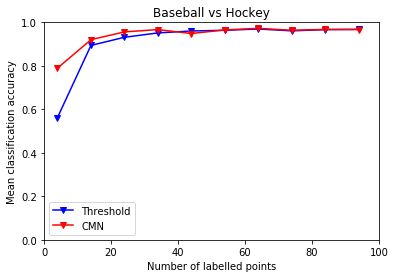

In [11]:
plt.plot(y,tr_bahoc,'bv-')
plt.plot(y,cr_bahoc,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Baseball vs Hockey')

Text(0.5,1,'PC vs MAC')

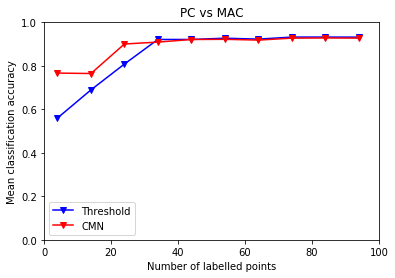

In [12]:
plt.plot(y,tr_pcmac,'bv-')
plt.plot(y,cr_pcmac,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('PC vs MAC')

Text(0.5,1,'Windows vs MAC')

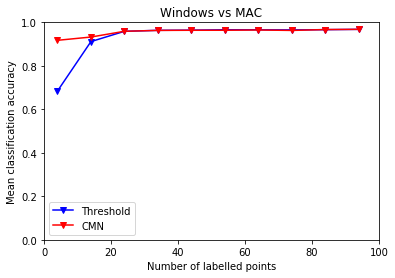

In [13]:
plt.plot(y,tr_wimac,'bv-')
plt.plot(y,cr_wimac,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Windows vs MAC')

## Hadnwritten Digits

### 2 Classes

In [2]:
two_classes_paths = ["./handwritten_digits/odd_vs_even/handwritten_digits_oddeven_x.txt","./handwritten_digits/one_vs_two/handwritten_digits_onetwo_x.txt"]

nn3 = image_to_NNgraph(paths=two_classes_paths,num_neighbours=3,radius=380)
nn10 = image_to_NNgraph(paths=two_classes_paths,num_neighbours=10,radius=380)

results_3NN = nn3.NNGraph()
results_10NN = nn10.NNGraph()
results_complete = nn3.CompleteGraph()

This graph is connected:  True
This graph is connected:  True
Run time:  9.574496984481812
This graph is connected:  True
This graph is connected:  True
Run time:  10.517753839492798
This graph is connected:  True
This graph is connected:  True
Run time:  308.66805386543274


In [352]:
oddeve3NN_G = results_3NN[0]
onetwo3NN_G = results_3NN[1]

oddeve10NN_G = results_10NN[0]
onetwo10NN_G = results_10NN[1]

oddeveComp_G = results_complete[0]
onetwoComp_G = results_complete[1]

oddeve_lab = pd.read_csv(filepath_or_buffer="./handwritten_digits/odd_vs_even/labels.csv",header=None)[1].values
onetwo_lab = pd.read_csv(filepath_or_buffer="./handwritten_digits/one_vs_two/labels.csv",header=None)[1].values

oddeve_label = dict(zip(np.arange(oddeve_lab.shape[0]), oddeve_lab))
onetwo_label = dict(zip(np.arange(onetwo_lab.shape[0]), onetwo_lab))
nx.set_node_attributes(G=oddeve3NN_G, name='label', values=oddeve_label)
nx.set_node_attributes(G=onetwo3NN_G, name='label', values=onetwo_label)
nx.set_node_attributes(G=oddeve10NN_G, name='label', values=oddeve_label)
nx.set_node_attributes(G=onetwo10NN_G, name='label', values=onetwo_label)
nx.set_node_attributes(G=oddeveComp_G, name='label', values=oddeve_label)
nx.set_node_attributes(G=onetwoComp_G, name='label', values=onetwo_label)

y = range(4, 100, 10)

In [387]:
oddeve3NN_model = LPA(graph=oddeve3NN_G,params={'NUM_CLASSES':2})
tr_oddeve_3NN,cr_oddeve_3NN = oddeve3NN_model.demo()

onetwo3NN_model = LPA(graph=onetwo3NN_G,params={'NUM_CLASSES':2})
tr_onetwo_3NN,cr_onetwo_3NN = onetwo3NN_model.demo()

oddeve10NN_model = LPA(graph=oddeve10NN_G,params={'NUM_CLASSES':2})
tr_oddeve_10NN,cr_oddeve_10NN = oddeve10NN_model.demo()

onetwo10NN_model = LPA(graph=onetwo10NN_G,params={'NUM_CLASSES':2})
tr_onetwo_10NN,cr_onetwo_10NN = onetwo10NN_model.demo()

oddeveComp_model = LPA(graph=oddeveComp_G,params={'NUM_CLASSES':2})
tr_oddeveComp,cr_oddeveComp = oddeveComp_model.demo()

onetwoComp_model = LPA(graph=onetwoComp_G,params={'NUM_CLASSES':2})
tr_onetwoComp,cr_onetwoComp = onetwoComp_model.demo()

numTrain 4  numTrail 1
numTrain 4  numTrail 2
numTrain 4  numTrail 3
numTrain 4  numTrail 4
numTrain 4  numTrail 5
numTrain 4  numTrail 6
numTrain 4  numTrail 7
numTrain 4  numTrail 8
numTrain 4  numTrail 9
numTrain 4  numTrail 10
numTrain 14  numTrail 1
numTrain 14  numTrail 2
numTrain 14  numTrail 3
numTrain 14  numTrail 4
numTrain 14  numTrail 5
numTrain 14  numTrail 6
numTrain 14  numTrail 7
numTrain 14  numTrail 8
numTrain 14  numTrail 9
numTrain 14  numTrail 10
numTrain 24  numTrail 1
numTrain 24  numTrail 2
numTrain 24  numTrail 3
numTrain 24  numTrail 4
numTrain 24  numTrail 5
numTrain 24  numTrail 6
numTrain 24  numTrail 7
numTrain 24  numTrail 8
numTrain 24  numTrail 9
numTrain 24  numTrail 10
numTrain 34  numTrail 1
numTrain 34  numTrail 2
numTrain 34  numTrail 3
numTrain 34  numTrail 4
numTrain 34  numTrail 5
numTrain 34  numTrail 6
numTrain 34  numTrail 7
numTrain 34  numTrail 8
numTrain 34  numTrail 9
numTrain 34  numTrail 10
numTrain 44  numTrail 1
numTrain 44  numTrail 

numTrain 44  numTrail 3
numTrain 44  numTrail 4
numTrain 44  numTrail 5
numTrain 44  numTrail 6
numTrain 44  numTrail 7
numTrain 44  numTrail 8
numTrain 44  numTrail 9
numTrain 44  numTrail 10
numTrain 54  numTrail 1
numTrain 54  numTrail 2
numTrain 54  numTrail 3
numTrain 54  numTrail 4
numTrain 54  numTrail 5
numTrain 54  numTrail 6
numTrain 54  numTrail 7
numTrain 54  numTrail 8
numTrain 54  numTrail 9
numTrain 54  numTrail 10
numTrain 64  numTrail 1
numTrain 64  numTrail 2
numTrain 64  numTrail 3
numTrain 64  numTrail 4
numTrain 64  numTrail 5
numTrain 64  numTrail 6
numTrain 64  numTrail 7
numTrain 64  numTrail 8
numTrain 64  numTrail 9
numTrain 64  numTrail 10
numTrain 74  numTrail 1
numTrain 74  numTrail 2
numTrain 74  numTrail 3
numTrain 74  numTrail 4
numTrain 74  numTrail 5
numTrain 74  numTrail 6
numTrain 74  numTrail 7
numTrain 74  numTrail 8
numTrain 74  numTrail 9
numTrain 74  numTrail 10
numTrain 84  numTrail 1
numTrain 84  numTrail 2
numTrain 84  numTrail 3
numTrain 84 

Text(0.5,1,'3NN Graph Odd vs Even')

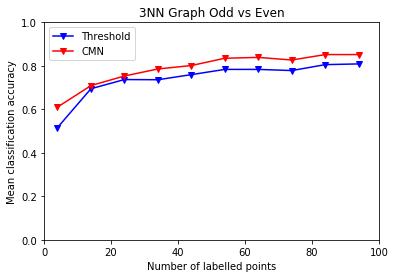

In [388]:
plt.plot(y, tr_oddeve_3NN,'bv-')
plt.plot(y, cr_oddeve_3NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('3NN Graph Odd vs Even')

Text(0.5,1,'3NN Graph One vs Two')

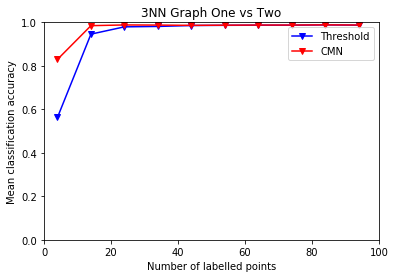

In [389]:
plt.plot(y, tr_onetwo_3NN,'bv-')
plt.plot(y, cr_onetwo_3NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('3NN Graph One vs Two')

Text(0.5,1,'10NN Graph Odd vs Even')

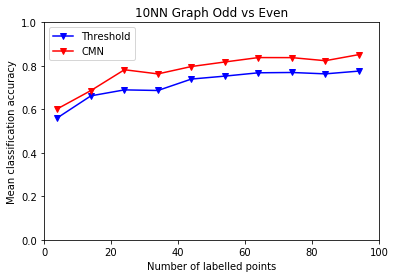

In [390]:
plt.plot(y, tr_oddeve_10NN,'bv-')
plt.plot(y, cr_oddeve_10NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('10NN Graph Odd vs Even')

Text(0.5,1,'10NN Graph One vs Two')

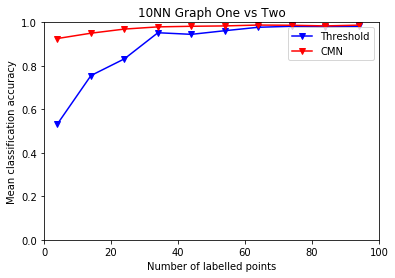

In [391]:
plt.plot(y, tr_onetwo_10NN,'bv-')
plt.plot(y, cr_onetwo_10NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('10NN Graph One vs Two')

Text(0.5,1,'Complete Graph Odd vs Even')

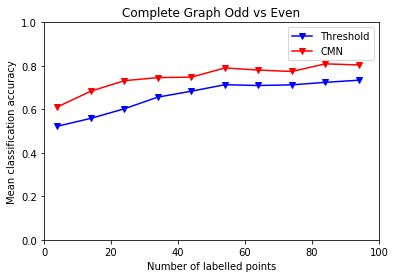

In [392]:
plt.plot(y, tr_oddeveComp,'bv-')
plt.plot(y, cr_oddeveComp,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Complete Graph Odd vs Even')

Text(0.5,1,'Complete Graph One vs Two')

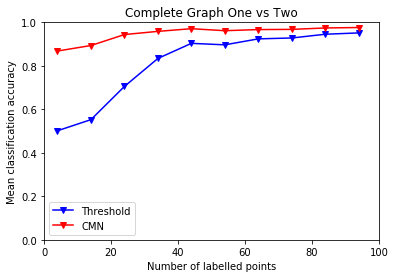

In [393]:
plt.plot(y, tr_onetwoComp,'bv-')
plt.plot(y, cr_onetwoComp,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Complete Graph One vs Two')

Text(0.5,1,'3NN Graph Odd vs Even')

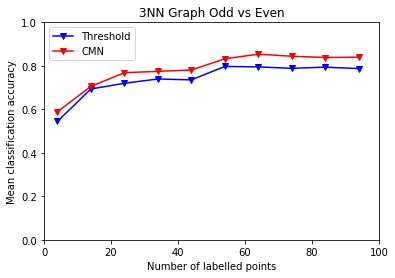

In [222]:
plt.plot(y, tr_oddeve_3NN,'bv-')
plt.plot(y, cr_oddeve_3NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('3NN Graph Odd vs Even')

Text(0.5,1,'3NN Graph One vs Two')

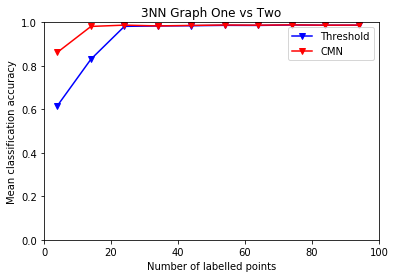

In [223]:
plt.plot(y, tr_onetwo_3NN,'bv-')
plt.plot(y, cr_onetwo_3NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('3NN Graph One vs Two')

Text(0.5,1,'10NN Graph Odd vs Even')

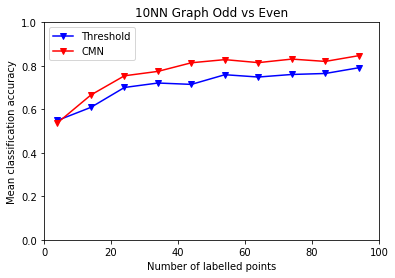

In [224]:
plt.plot(y, tr_oddeve_10NN,'bv-')
plt.plot(y, cr_oddeve_10NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('10NN Graph Odd vs Even')

Text(0.5,1,'10NN Graph One vs Two')

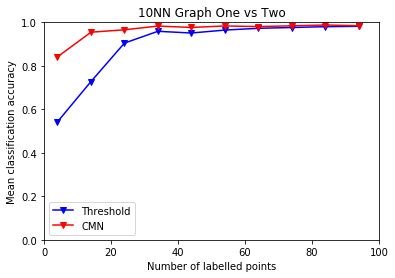

In [225]:
plt.plot(y, tr_onetwo_10NN,'bv-')
plt.plot(y, cr_onetwo_10NN,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('10NN Graph One vs Two')

Text(0.5,1,'Complete Graph Odd vs Even')

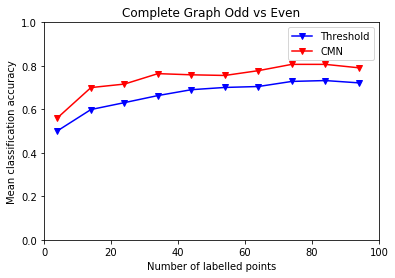

In [226]:
plt.plot(y, tr_oddeveComp,'bv-')
plt.plot(y, cr_oddeveComp,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Complete Graph Odd vs Even')

Text(0.5,1,'Complete Graph One vs Two')

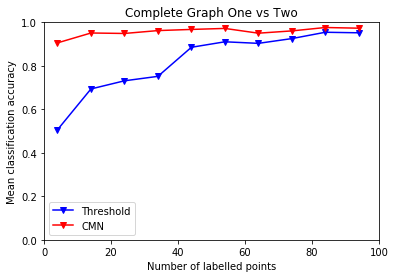

In [227]:
plt.plot(y, tr_onetwoComp,'bv-')
plt.plot(y, cr_onetwoComp,'rv-')
plt.xlim(0,100)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Complete Graph One vs Two')

### 10 Classes

In [14]:
ten_classes_paths = ["./handwritten_digits/ten_classes/handwritten_digits_tencls_x.txt"]
Ten_nn3 = image_to_NNgraph(paths=ten_classes_paths,num_neighbours=3,radius=380)
Ten_nn10 = image_to_NNgraph(paths=ten_classes_paths,num_neighbours=10,radius=380)

Ten_results_3NN = Ten_nn3.NNGraph()
Ten_results_10NN = Ten_nn10.NNGraph()
Ten_results_complete = Ten_nn3.CompleteGraph()

This graph is connected:  True
Run time:  7.469506740570068


In [15]:
tencls3NN_G = Ten_results_3NN[0]
tencls10NN_G = Ten_results_10NN[0]
tenclsComp_G = Ten_results_complete[0]

tencls_lab = pd.read_csv(filepath_or_buffer="./handwritten_digits/ten_classes/labels.csv",header=None)[1].values

tencls_label = dict(zip(np.arange(tencls_lab.shape[0]), tencls_lab))

nx.set_node_attributes(G=tencls3NN_G, name='label', values=tencls_label)
nx.set_node_attributes(G=tencls10NN_G, name='label', values=tencls_label)
nx.set_node_attributes(G=tenclsComp_G, name='label', values=tencls_label)



In [20]:
tencls3NN_model = LPA(graph=tencls3NN_G,params={'NUM_CLASSES':10, 'NUM_TRAIN': range(14, 200, 10)})
tr_tencls_3NN,cr_tencls_3NN = tencls3NN_model.demo()

tencls10NN_model = LPA(graph=tencls10NN_G,params={'NUM_CLASSES':10, 'NUM_TRAIN': range(14, 200, 10)})
tr_tencls_10NN,cr_tencls_10NN = tencls10NN_model.demo()

tenclsComp_model = LPA(graph=tenclsComp_G,params={'NUM_CLASSES':10, 'NUM_TRAIN': range(14, 200, 10)})
tr_tenclsComp,cr_tenclsComp = tenclsComp_model.demo()

In [21]:
y = range(14, 200, 10)

Text(0.5,1,'3NN Ten Classes')

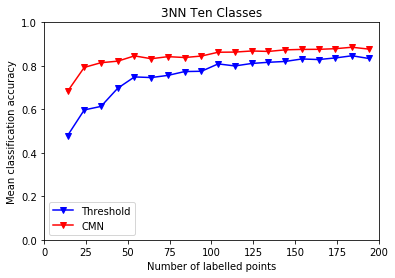

In [22]:
plt.plot(y,tr_tencls_3NN,'bv-')
plt.plot(y,cr_tencls_3NN,'rv-')
plt.xlim(0,200)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('3NN Ten Classes')

Text(0.5,1,'10NN Ten Classes')

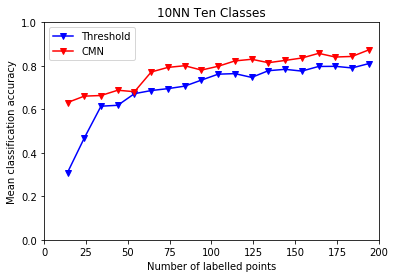

In [218]:
plt.plot(y,tr_tencls_10NN,'bv-')
plt.plot(y,cr_tencls_10NN,'rv-')
plt.xlim(0,200)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('10NN Ten Classes')

Text(0.5,1,'Complete Graph Ten Classes')

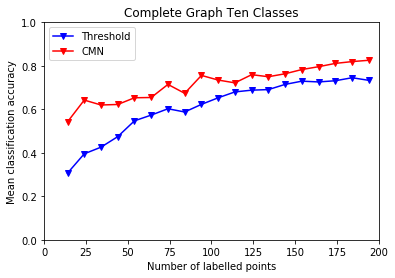

In [217]:
plt.plot(y,tr_tenclsComp,'bv-')
plt.plot(y,cr_tenclsComp,'rv-')
plt.xlim(0,200)
plt.ylim(0.0, 1.0)
plt.xlabel('Number of labelled points')
plt.ylabel('Mean classification accuracy')
plt.legend(('Threshold','CMN'))
plt.title('Complete Graph Ten Classes')